In [1]:
import xarray as xr
import cmocean 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy
import cartopy.crs as ccrs
import cftime
import numpy as np

In [2]:
xr.set_options(display_style='html')
%matplotlib inline                           
%config InlineBackend.figure_format='retina' 
plt.rcParams['figure.figsize'] = 12,6

## Assessment of Geostrophic Balance
This dataset contains:
- sea surface height (SSH --> zos) (referenced to a global mean of zero)
- zonal (u --> uo) and meridional (v --> vo) velocities 
at daily temporal resolution.


Goal is to assess the accuracy of the geostrophic balance approximation:
- step: horizontal gradient estimation (dh/dx, dh/dy --> convert lat/lon to distance) 
- step: geostrophic velocity estimation (leverage the geostrophic balance relationship to find geostrophic velocities u_g, v_g)
- step: calculate difference between surface velocities (uo,vo) and surface geostrophic velocities (difference between u and u_g, v and v_g)


Questions to address/explore:
- question 1: consider and plot differences between u_g and uo, v_g and vo as a function of timescale (e.g. using a single time slice vs. a long time mean)
- question 2: how sensitive are results to the length scale over which a gradient is calculated? (remember velocities have to be averaged across the same length scale). Choose a second length scale to compute gradient and estimate velocity difference (think of center difference methods and/or linear slope fitting)
- question 3: compute relative vorticity at a single time slice and for the time mean

In [3]:
glorys_jan_mar_2021 = xr.open_zarr('../data/glorys_jan_mar_2021_daily_surface')

In [4]:
zos = glorys_jan_mar_2021.zos.isel(time=20).load()

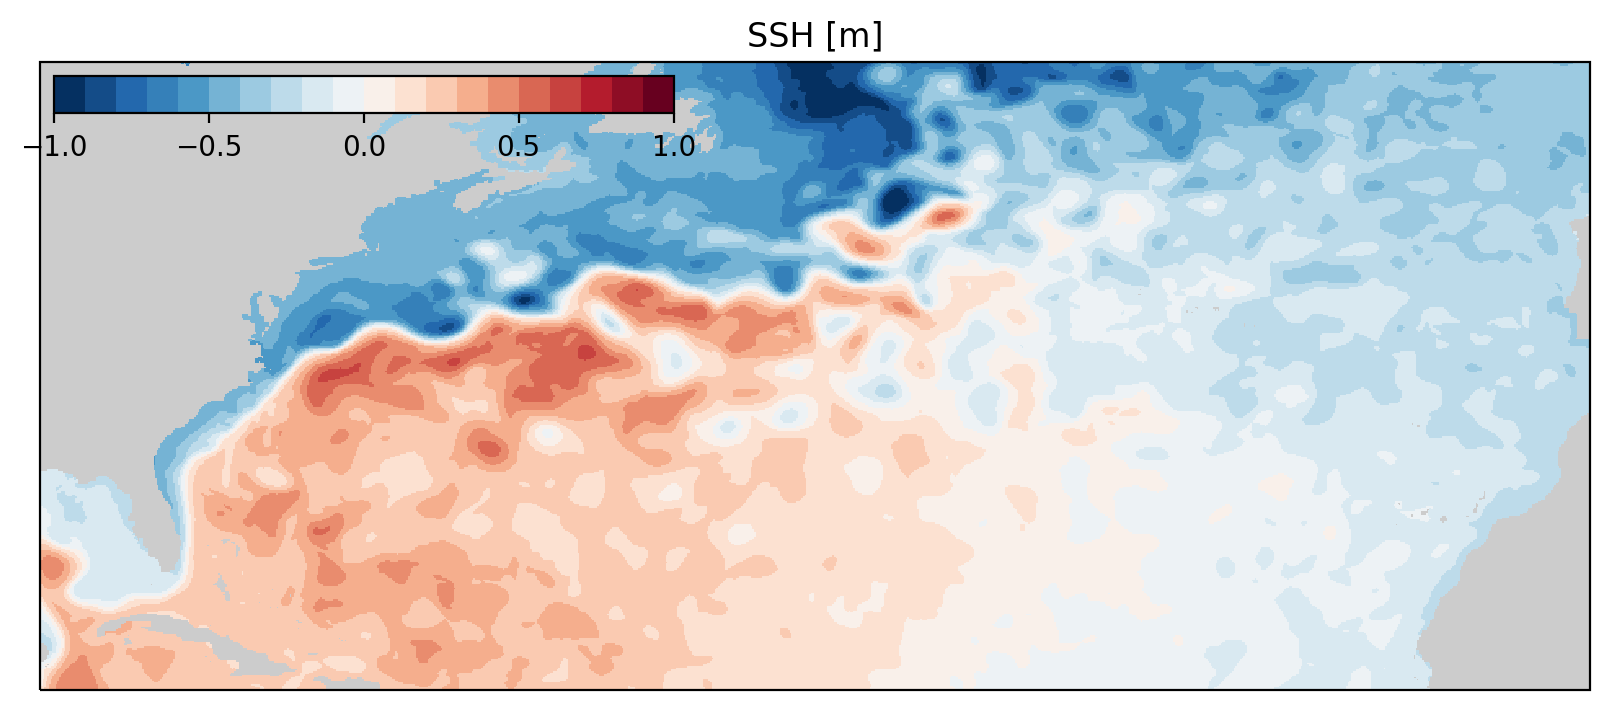

In [5]:
f, ax = plt.subplots(1,1,figsize=(10,8),subplot_kw={'projection':ccrs.PlateCarree()})
pp = ax.pcolor(zos.longitude, zos.latitude, zos, vmin=-1, vmax=1, \
          cmap=plt.get_cmap('RdBu_r',20),transform=ccrs.PlateCarree())
ax.set_facecolor('#cccccc')
ax.set_title('SSH [m]')
axins1 = inset_axes(ax, width="40%",height="6%",loc="upper left")
ax.xaxis.set_ticks_position("top")
f.colorbar(pp, cax=axins1, orientation="horizontal")
ax.grid()

In [6]:
# sample surface velocities
ss_u = glorys_jan_mar_2021.isel(time=20).uo.isel(depth=0).load()
ss_v = glorys_jan_mar_2021.isel(time=20).vo.isel(depth=0).load()
speed = 0.5*(ss_u**2 + ss_v**2)

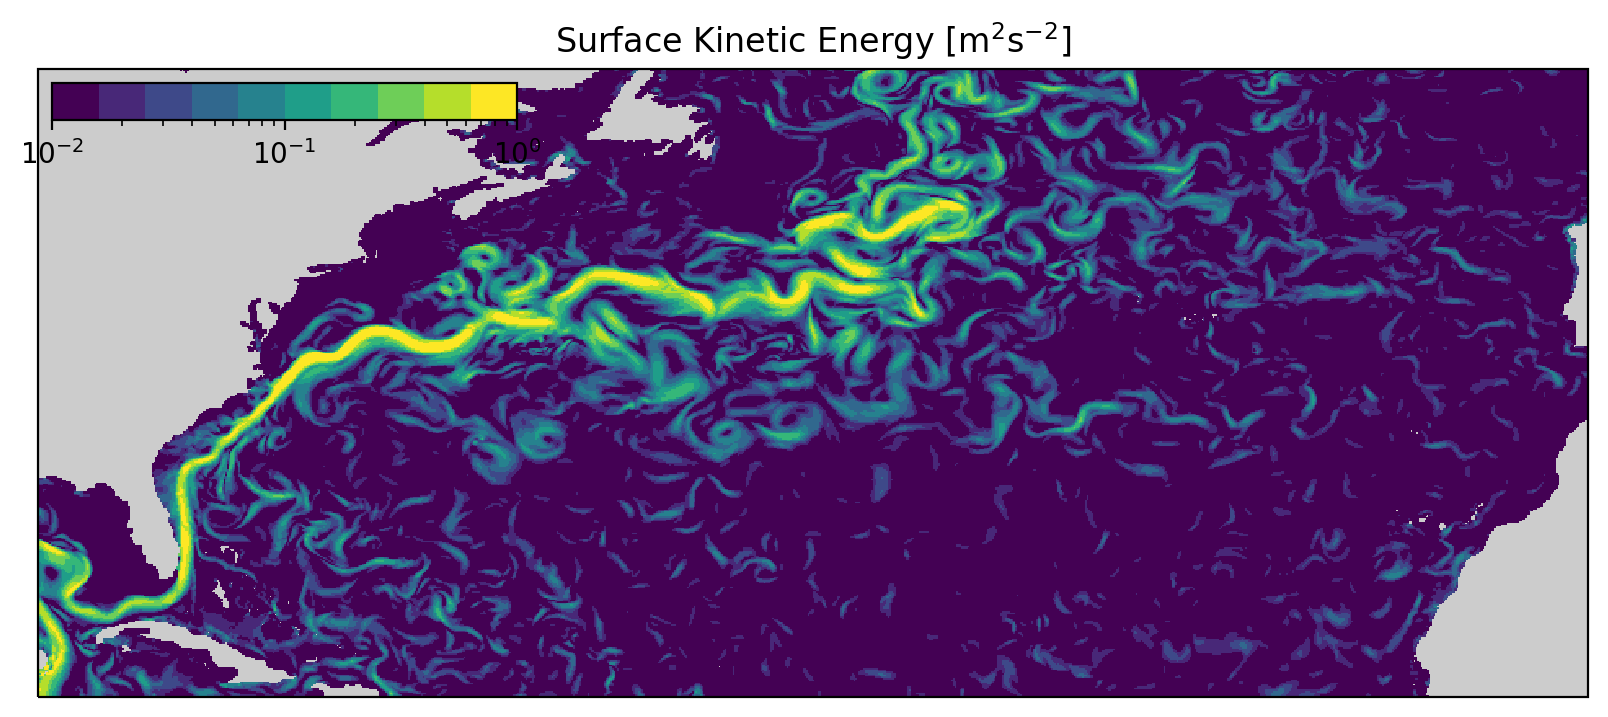

In [7]:
f, ax = plt.subplots(1,1,figsize=(10,8),subplot_kw={'projection':ccrs.PlateCarree()})
pp = ax.pcolor(ss_u.longitude, ss_u.latitude, speed, norm=LogNorm(vmin=0.01, vmax=1), \
          cmap=plt.get_cmap('viridis',10),transform=ccrs.PlateCarree())
ax.set_title(r'Surface Kinetic Energy [m$^2$s$^{-2}$]')
ax.set_facecolor('#cccccc')
axins1 = inset_axes(ax, width="30%",height="6%",loc="upper left")
ax.xaxis.set_ticks_position("top")
f.colorbar(pp, cax=axins1, orientation="horizontal")
ax.grid()

#### dx = 1852 * 60 * cos(lat) * (lon_n - lon_n-1)
#### convert deg to rad
#### dy = 1852 * 60 * (lat_n - lat_n-1)

## 1. consider and plot differences between u_g and uo, v_g and vo as a function of timescale (e.g. using a single time slice vs. a long time mean)

## $$ v_g = g/f (dh/dx) $$ 
## $$ u_g = -g/f (dh/dy) $$

In [9]:
glorys_time_mean = glorys_jan_mar_2021.mean('time')
glorys_time_start = glorys_jan_mar_2021.isel(time=0)
glorys_time_end = glorys_jan_mar_2021.isel(time=-1)


In [11]:
# def make_dx(lat, lon1, lon0):
#     dx = 1852 * 60 * np.cos(np.deg2grad(lat)) * (lon1 - lon00)
#     return dx

# def make_dy(lat1, lat0):
#     dy = 1852 * 60 * (lat1 - lat0)
#     return dy

In [12]:
# for j in range(1, len(lat)+1):
#     print(j)

In [13]:
# # def make_dist_grid():
# grid = np.empty((len(glorys_time_mean.latitude), len(glorys_time_mean.longitude)))
# for j in range(1, len(glorys_time_mean.latitude)):
#     for i in range(1, len(glorys_time_mean.longitude)):
        
#         dLat = lat[j] - lat[j-1]
#         dLon = lon[i] - lon[i-1]
        
#         lon1 = lon[i] + dLon / 2
#         lon0 = lon[i] - dLon / 2
#         lat1 = lat[j] + dLat / 2
#         lat0 = lat[j] - dLat / 2
        
#         grid[j, i] = (
#             # np.abs(lon0 - lon1)
#         )

In [93]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Physical constants
g = 9.81  # gravity (m/s^2)
omega = 7.2921e-5  # Earth's rotation rate (rad/s)

# Calculate Coriolis parameter
f_time_mean = 2 * omega * np.sin(np.deg2rad(glorys_time_mean.latitude))

# Convert latitude/longitude to meters for gradients
R_earth = 6371e3  # Earth radius in meters
dy_time_mean = R_earth * np.deg2rad(glorys_time_mean.latitude.diff('latitude'))
dx_time_mean = R_earth * np.cos(np.deg2rad(glorys_time_mean.latitude)) * np.deg2rad(glorys_time_mean.longitude.diff('longitude'))

# Compute gradients of SSH
dzos_dy_time_mean = glorys_time_mean['zos'].differentiate('latitude') / dy_time_mean
dzos_dx_time_mean = glorys_time_mean['zos'].differentiate('longitude') / dx_time_mean

# Compute geostrophic velocities
u_g_time_mean = -(g / f_time_mean) * dzos_dy_time_mean
v_g_time_mean = (g / f_time_mean) * dzos_dx_time_mean

# Compute differences (ageostrophic component)
u_diff_time_mean = glorys_time_mean['uo'] - u_g_time_mean
v_diff_time_mean = glorys_time_mean['vo'] - v_g_time_mean



In [94]:
# Physical constants
g = 9.81  # gravity (m/s^2)
omega = 7.2921e-5  # Earth's rotation rate (rad/s)

# Calculate Coriolis parameter
f_time_start = 2 * omega * np.sin(np.deg2rad(glorys_time_start.latitude))

# Convert latitude/longitude to meters for gradients
R_earth = 6371e3  # Earth radius in meters
dy_time_start = R_earth * np.deg2rad(glorys_time_start.latitude.diff('latitude'))
dx_time_start = R_earth * np.cos(np.deg2rad(glorys_time_start.latitude)) * np.deg2rad(glorys_time_start.longitude.diff('longitude'))

# Compute gradients of SSH
dzos_dy_time_start = glorys_time_start['zos'].differentiate('latitude') / dy_time_start
dzos_dx_time_start = glorys_time_start['zos'].differentiate('longitude') / dx_time_start

# Compute geostrophic velocities
u_g_time_start = -(g / f_time_start) * dzos_dy_time_start
v_g_time_start = (g / f_time_start) * dzos_dx_time_start

# Compute differences (ageostrophic component)
u_diff_time_start = glorys_time_start['uo'] - u_g_time_start
v_diff_time_start = glorys_time_start['vo'] - v_g_time_start



In [95]:
# Physical constants
g = 9.81  # gravity (m/s^2)
omega = 7.2921e-5  # Earth's rotation rate (rad/s)

# Calculate Coriolis parameter
f_time_end = 2 * omega * np.sin(np.deg2rad(glorys_time_end.latitude))

# Convert latitude/longitude to meters for gradients
R_earth = 6371e3  # Earth radius in meters
dy_time_end = R_earth * np.deg2rad(glorys_time_end.latitude.diff('latitude'))
dx_time_end = R_earth * np.cos(np.deg2rad(glorys_time_end.latitude)) * np.deg2rad(glorys_time_end.longitude.diff('longitude'))

# Compute gradients of SSH
dzos_dy_time_end = glorys_time_end['zos'].differentiate('latitude') / dy_time_end
dzos_dx_time_end = glorys_time_end['zos'].differentiate('longitude') / dx_time_end

# Compute geostrophic velocities
u_g_time_end = -(g / f_time_end) * dzos_dy_time_end
v_g_time_end = (g / f_time_end) * dzos_dx_time_end

# Compute differences (ageostrophic component)
u_diff_time_end = glorys_time_end['uo'] - u_g_time_end
v_diff_time_end = glorys_time_end['vo'] - v_g_time_end



Text(0.5, 1.0, 'u_g')

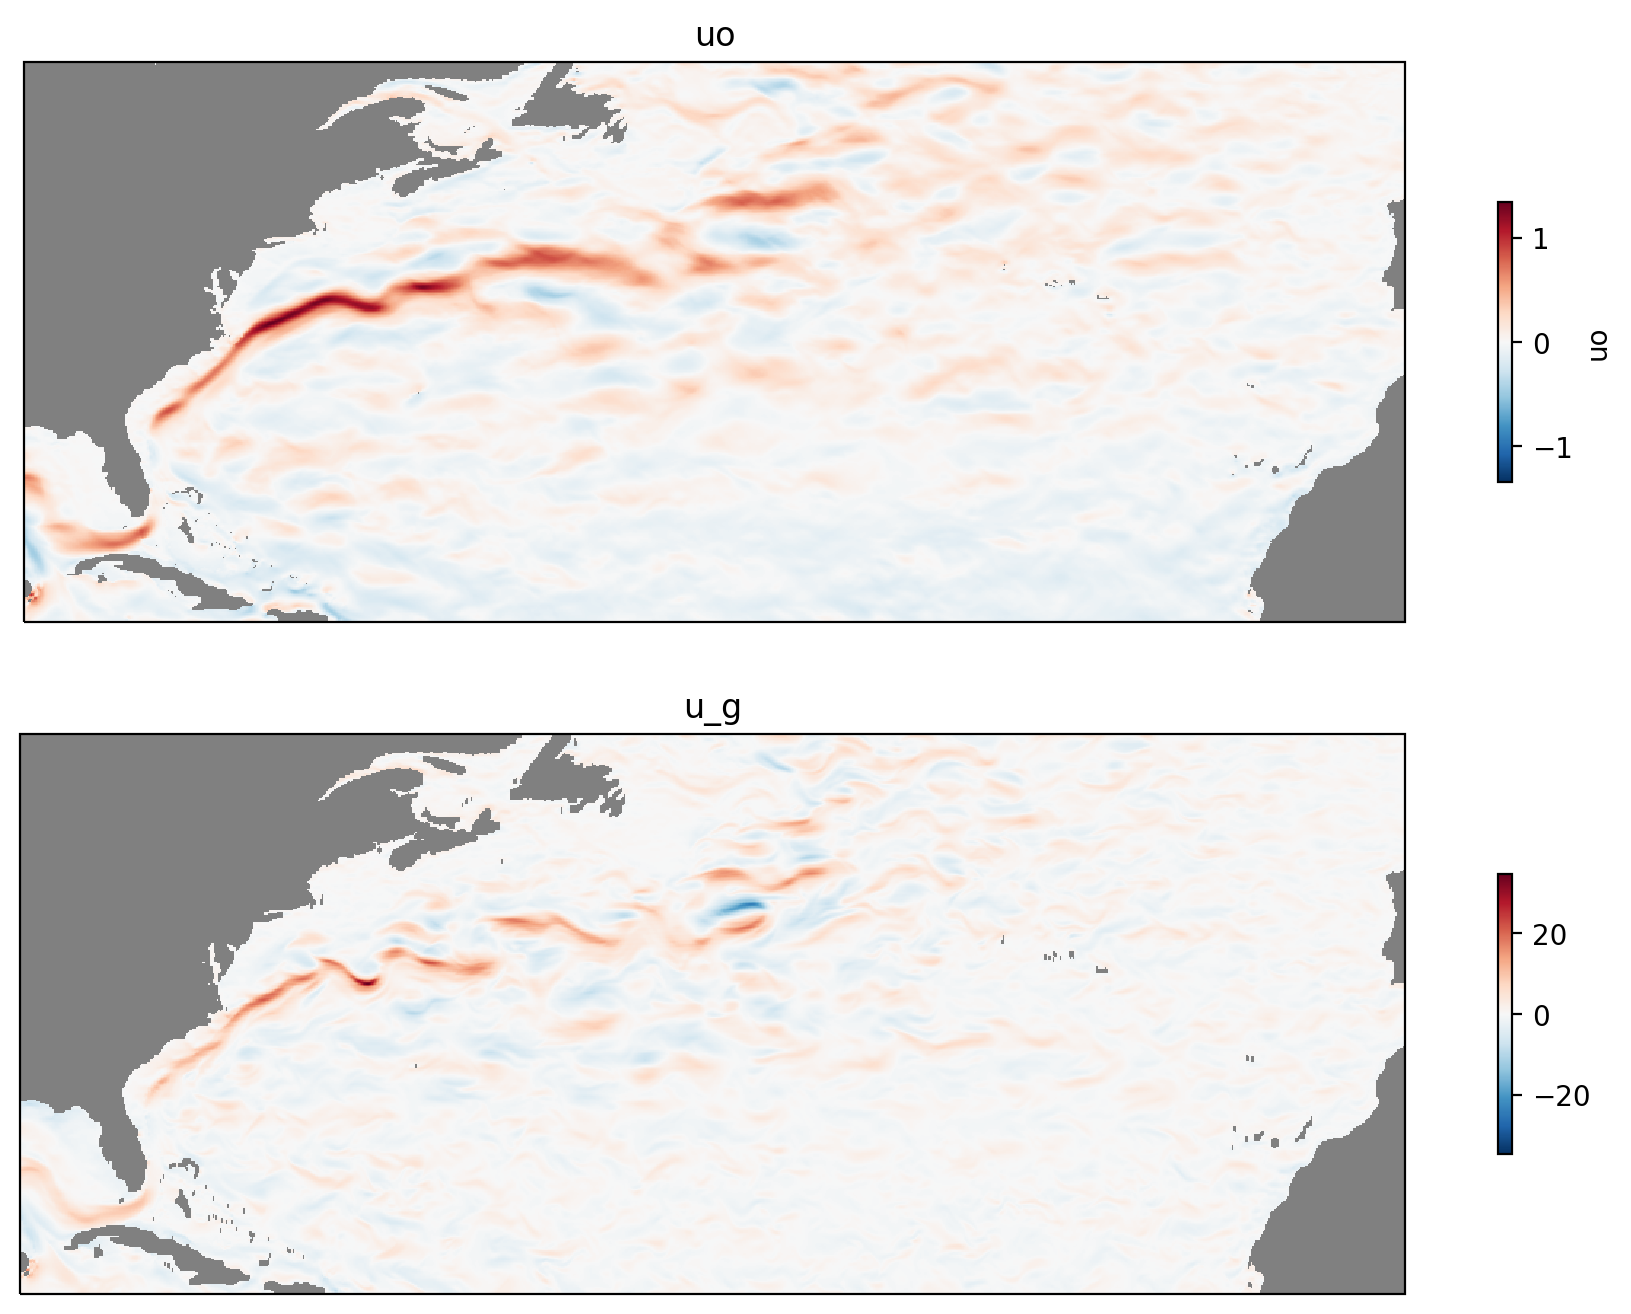

In [96]:
f, ax = plt.subplots(figsize=(12, 8),
                     nrows=2,
                     subplot_kw={'projection':ccrs.PlateCarree()})

glorys_time_mean.uo.plot(ax=ax[0], transform=ccrs.PlateCarree(), cbar_kwargs={'shrink':0.5})

u_g.plot(ax=ax[1], transform=ccrs.PlateCarree(), cbar_kwargs={'shrink':0.5})

ax[0].set_facecolor('gray')
ax[0].set_title('uo')

ax[1].set_facecolor('gray')
ax[1].set_title('u_g')

Text(0.5, 1.0, 'v_g')

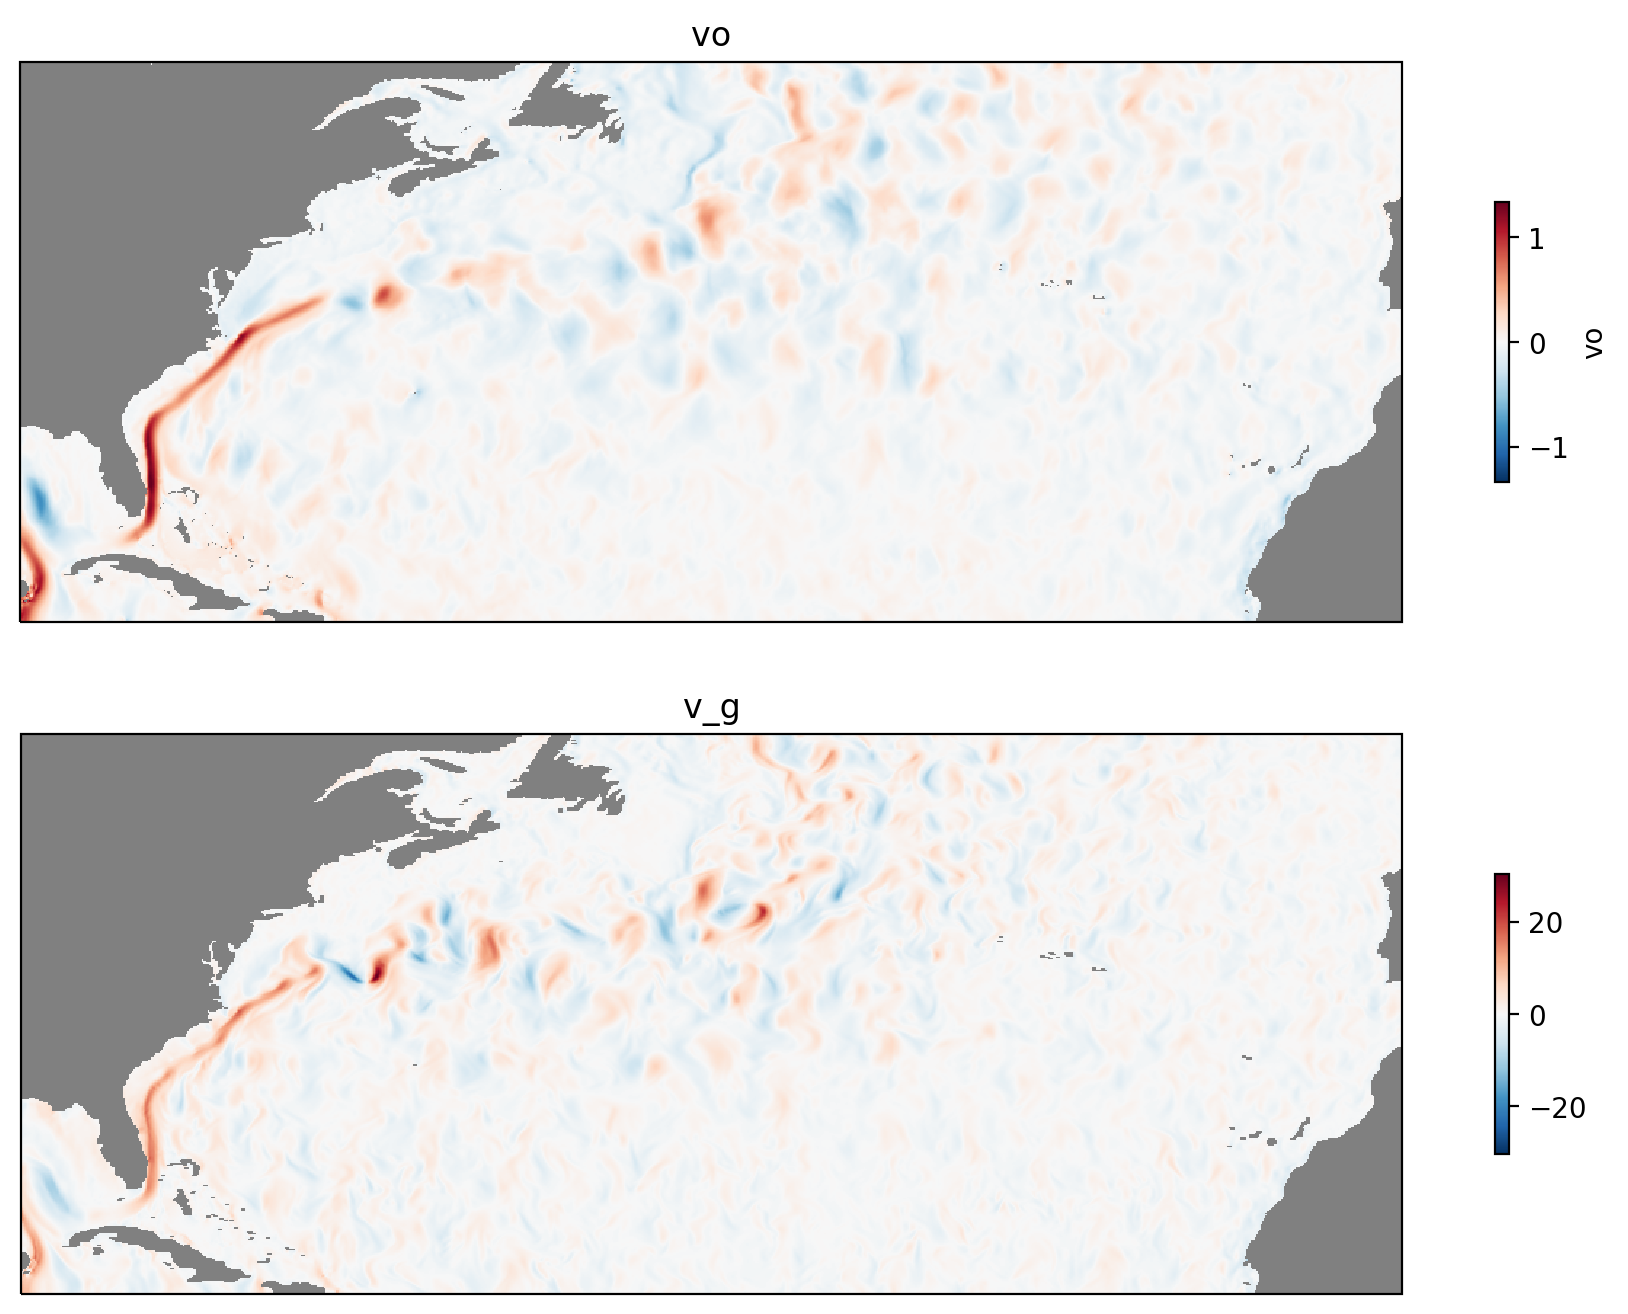

In [97]:
f, ax = plt.subplots(figsize=(12, 8),
                     nrows=2,
                     subplot_kw={'projection':ccrs.PlateCarree()})

glorys_time_mean.vo.plot(ax=ax[0], transform=ccrs.PlateCarree(), cbar_kwargs={'shrink':0.5})

v_g.plot(ax=ax[1], transform=ccrs.PlateCarree(), cbar_kwargs={'shrink':0.5})

ax[0].set_facecolor('gray')
ax[0].set_title('vo')

ax[1].set_facecolor('gray')
ax[1].set_title('v_g')

Text(0.5, 1.0, 'u_g')

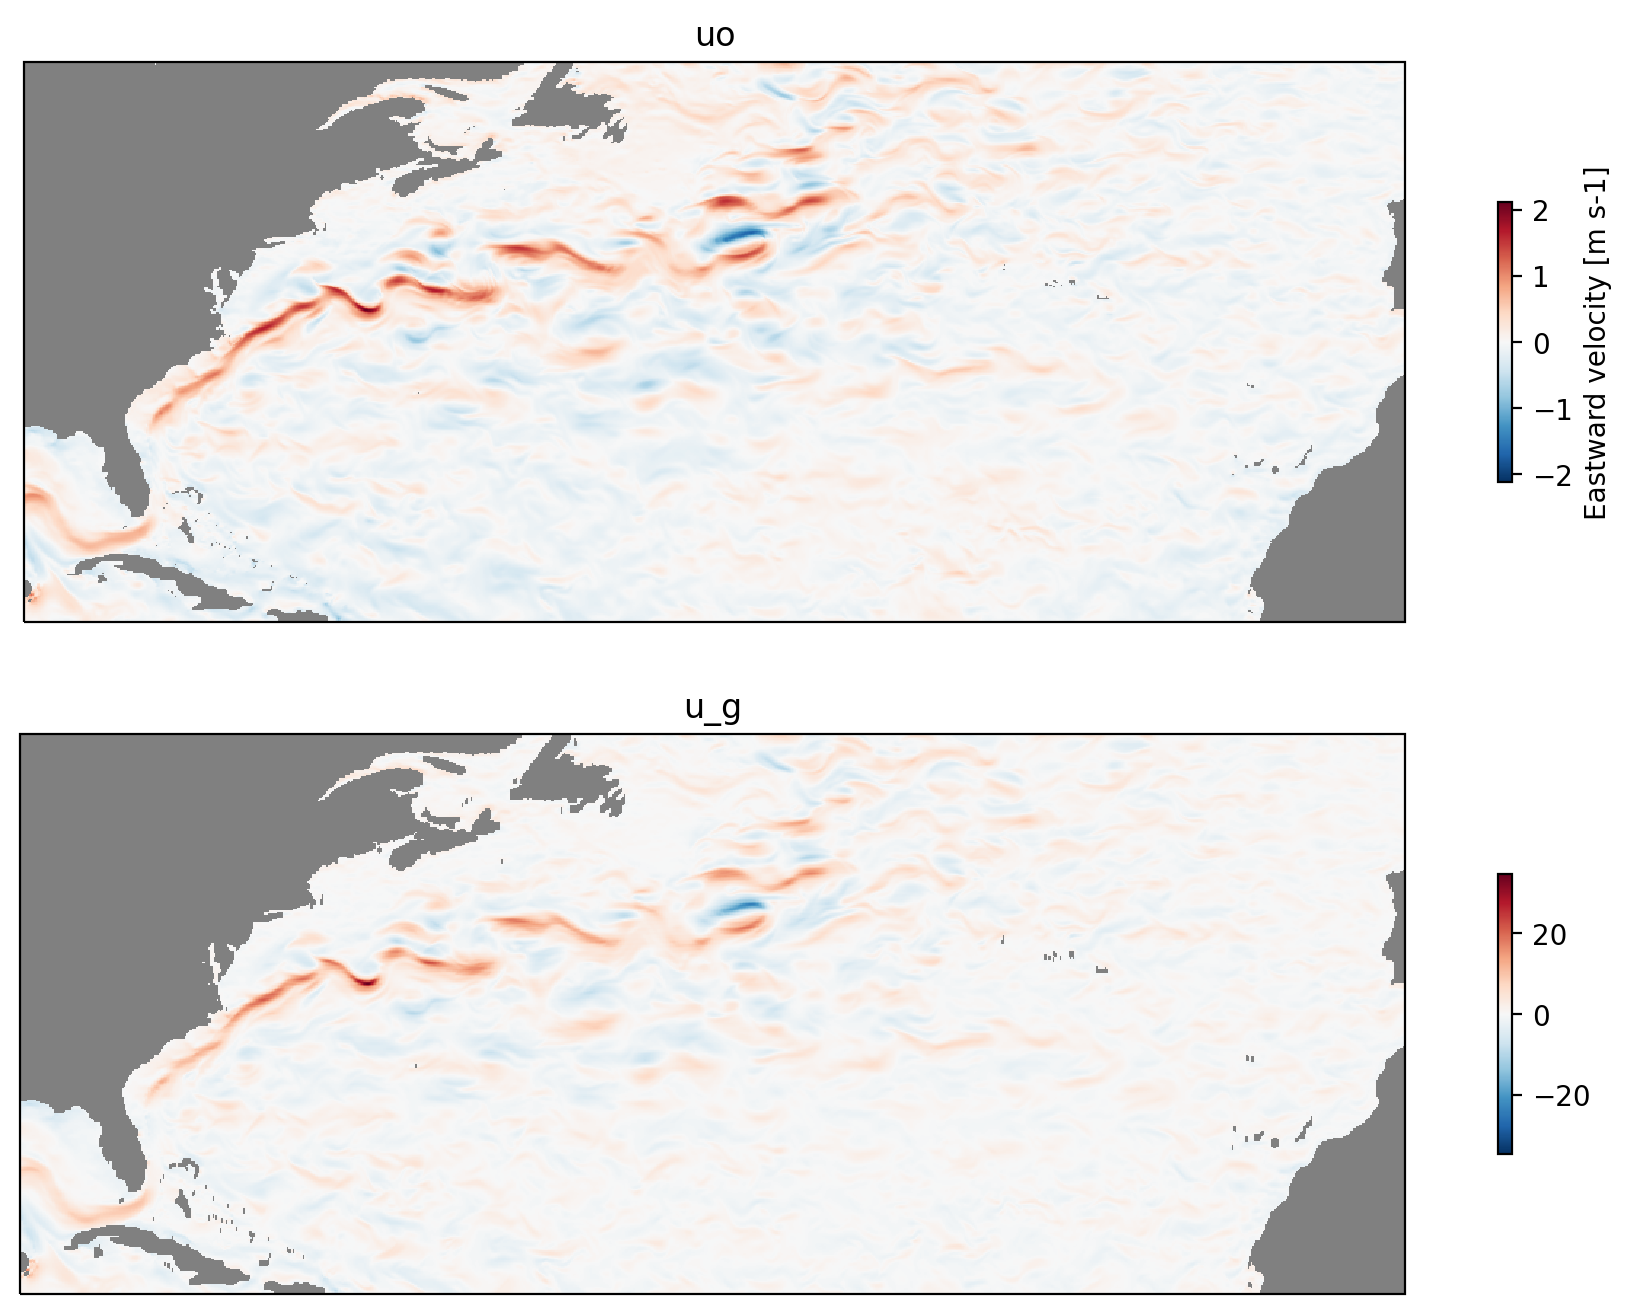

In [98]:
f, ax = plt.subplots(figsize=(12, 8),
                     nrows=2,
                     subplot_kw={'projection':ccrs.PlateCarree()})

glorys_time_start.uo.plot(ax=ax[0], transform=ccrs.PlateCarree(), cbar_kwargs={'shrink':0.5})

u_g_time_start.plot(ax=ax[1], transform=ccrs.PlateCarree(), cbar_kwargs={'shrink':0.5})

ax[0].set_facecolor('gray')
ax[0].set_title('uo')

ax[1].set_facecolor('gray')
ax[1].set_title('u_g')

Text(0.5, 1.0, 'v_g')

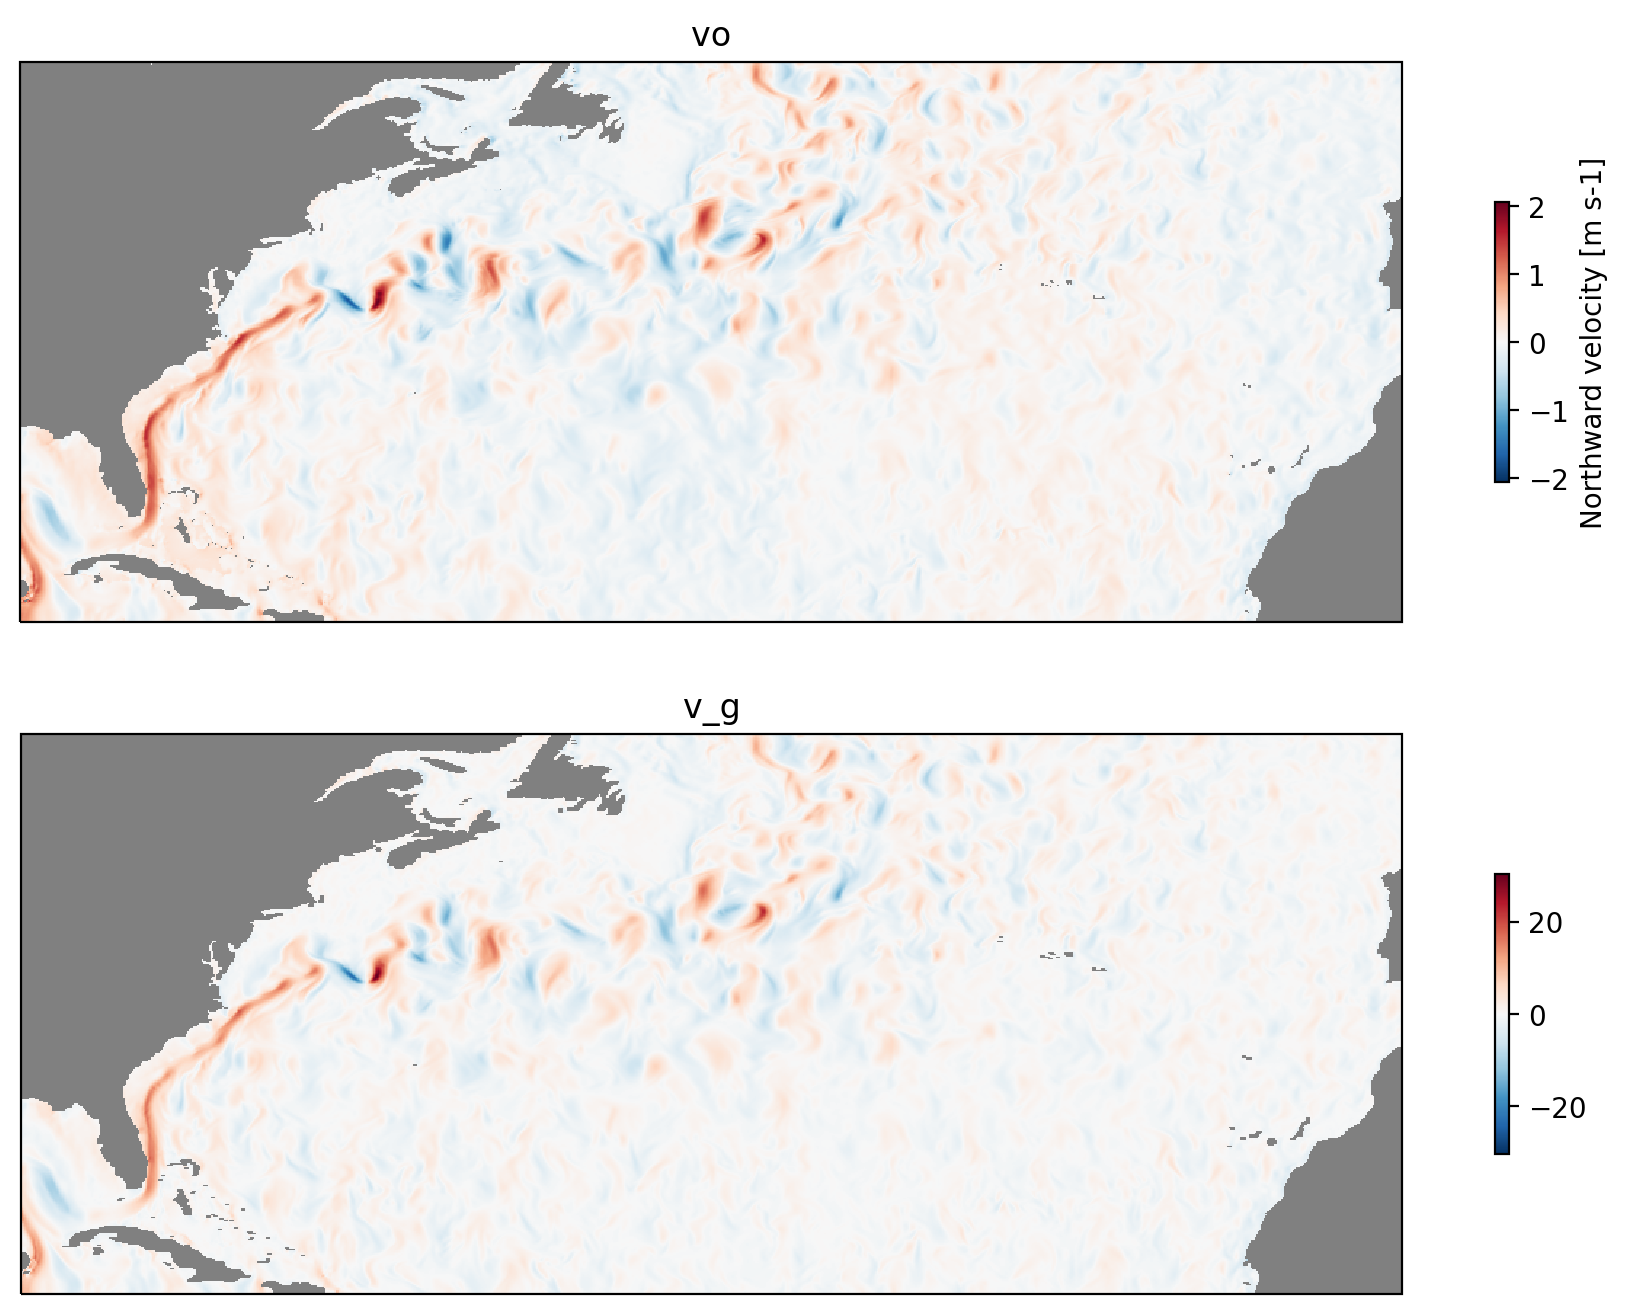

In [99]:
f, ax = plt.subplots(figsize=(12, 8),
                     nrows=2,
                     subplot_kw={'projection':ccrs.PlateCarree()})

glorys_time_start.vo.plot(ax=ax[0], transform=ccrs.PlateCarree(), cbar_kwargs={'shrink':0.5})

v_g_time_start.plot(ax=ax[1], transform=ccrs.PlateCarree(), cbar_kwargs={'shrink':0.5})

ax[0].set_facecolor('gray')
ax[0].set_title('vo')

ax[1].set_facecolor('gray')
ax[1].set_title('v_g')

Text(0.5, 1.0, 'u_g')

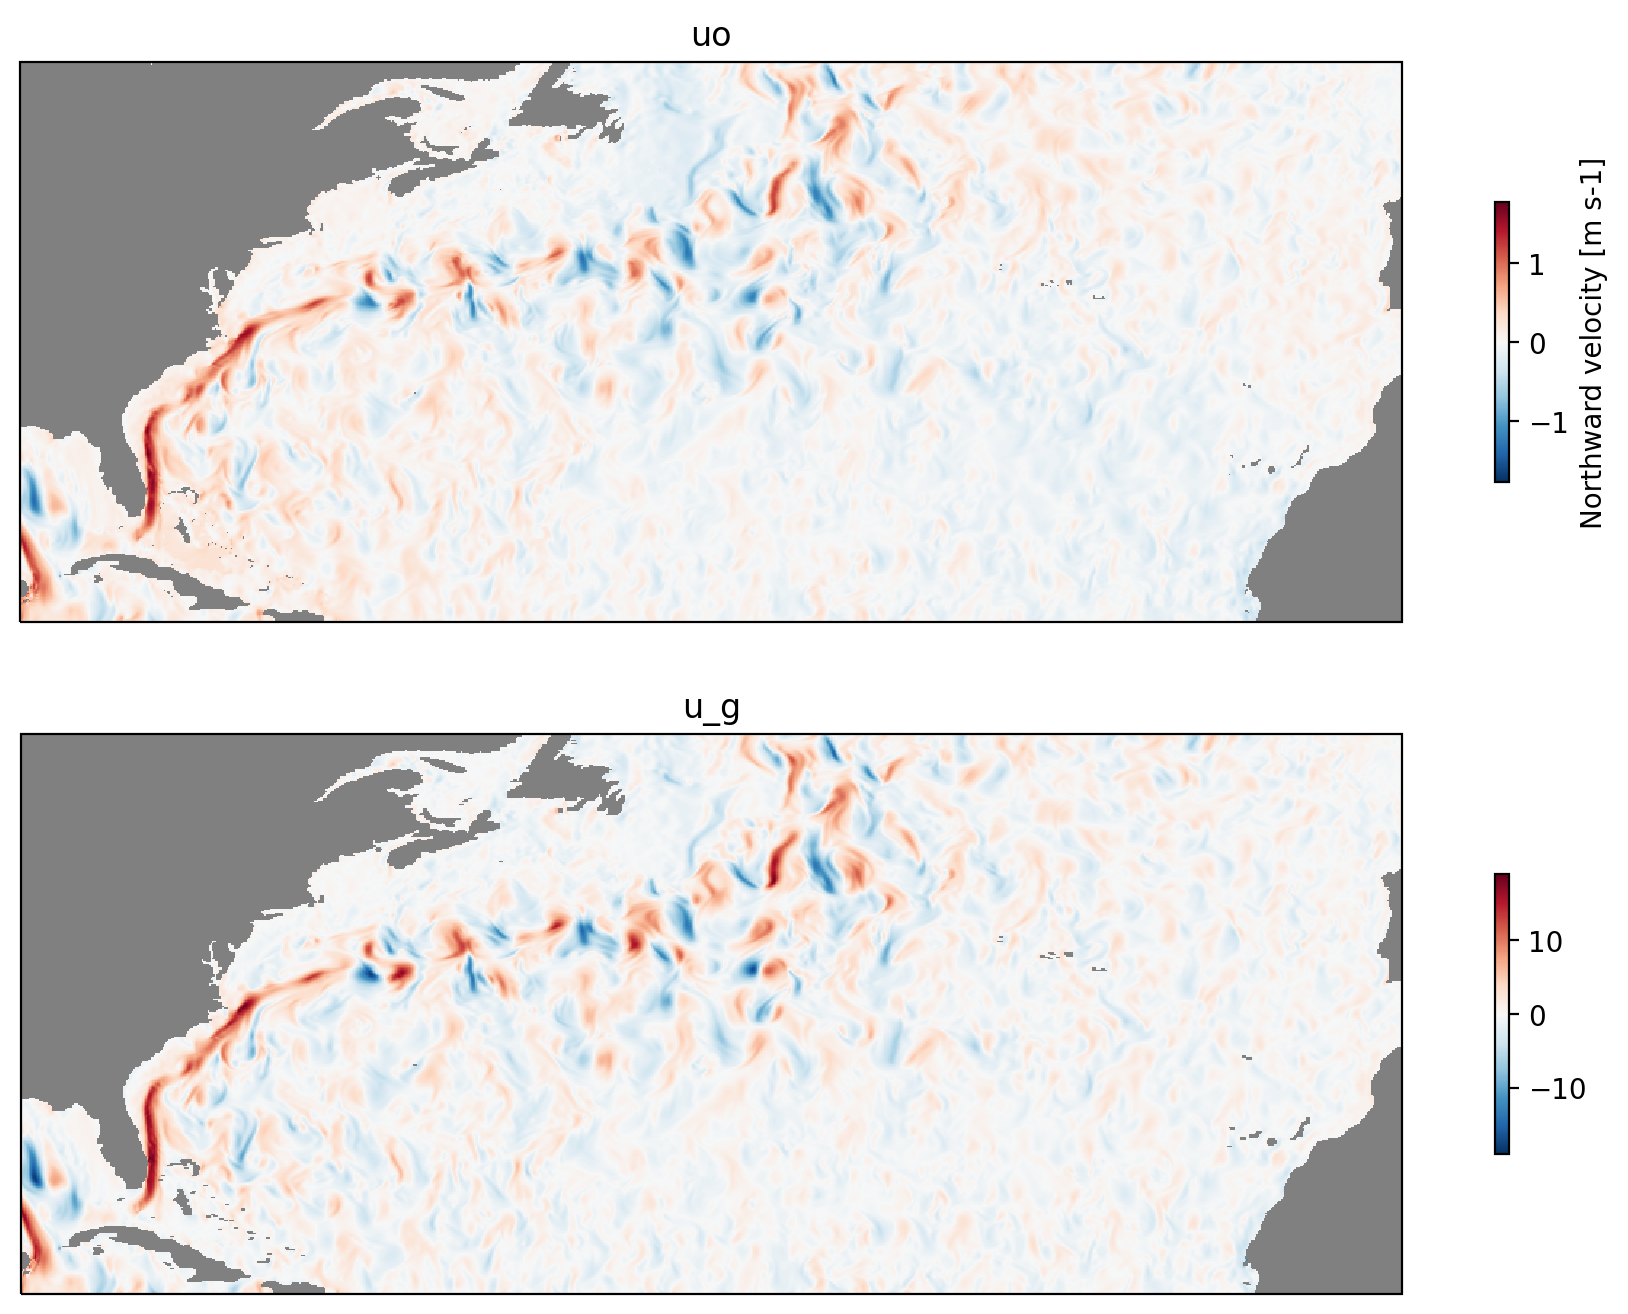

In [100]:
f, ax = plt.subplots(figsize=(12, 8),
                     nrows=2,
                     subplot_kw={'projection':ccrs.PlateCarree()})

glorys_time_end.vo.plot(ax=ax[0], transform=ccrs.PlateCarree(), cbar_kwargs={'shrink':0.5})

v_g_time_end.plot(ax=ax[1], transform=ccrs.PlateCarree(), cbar_kwargs={'shrink':0.5})

ax[0].set_facecolor('gray')
ax[0].set_title('uo')

ax[1].set_facecolor('gray')
ax[1].set_title('u_g')

Text(0.5, 1.0, 'v_g')

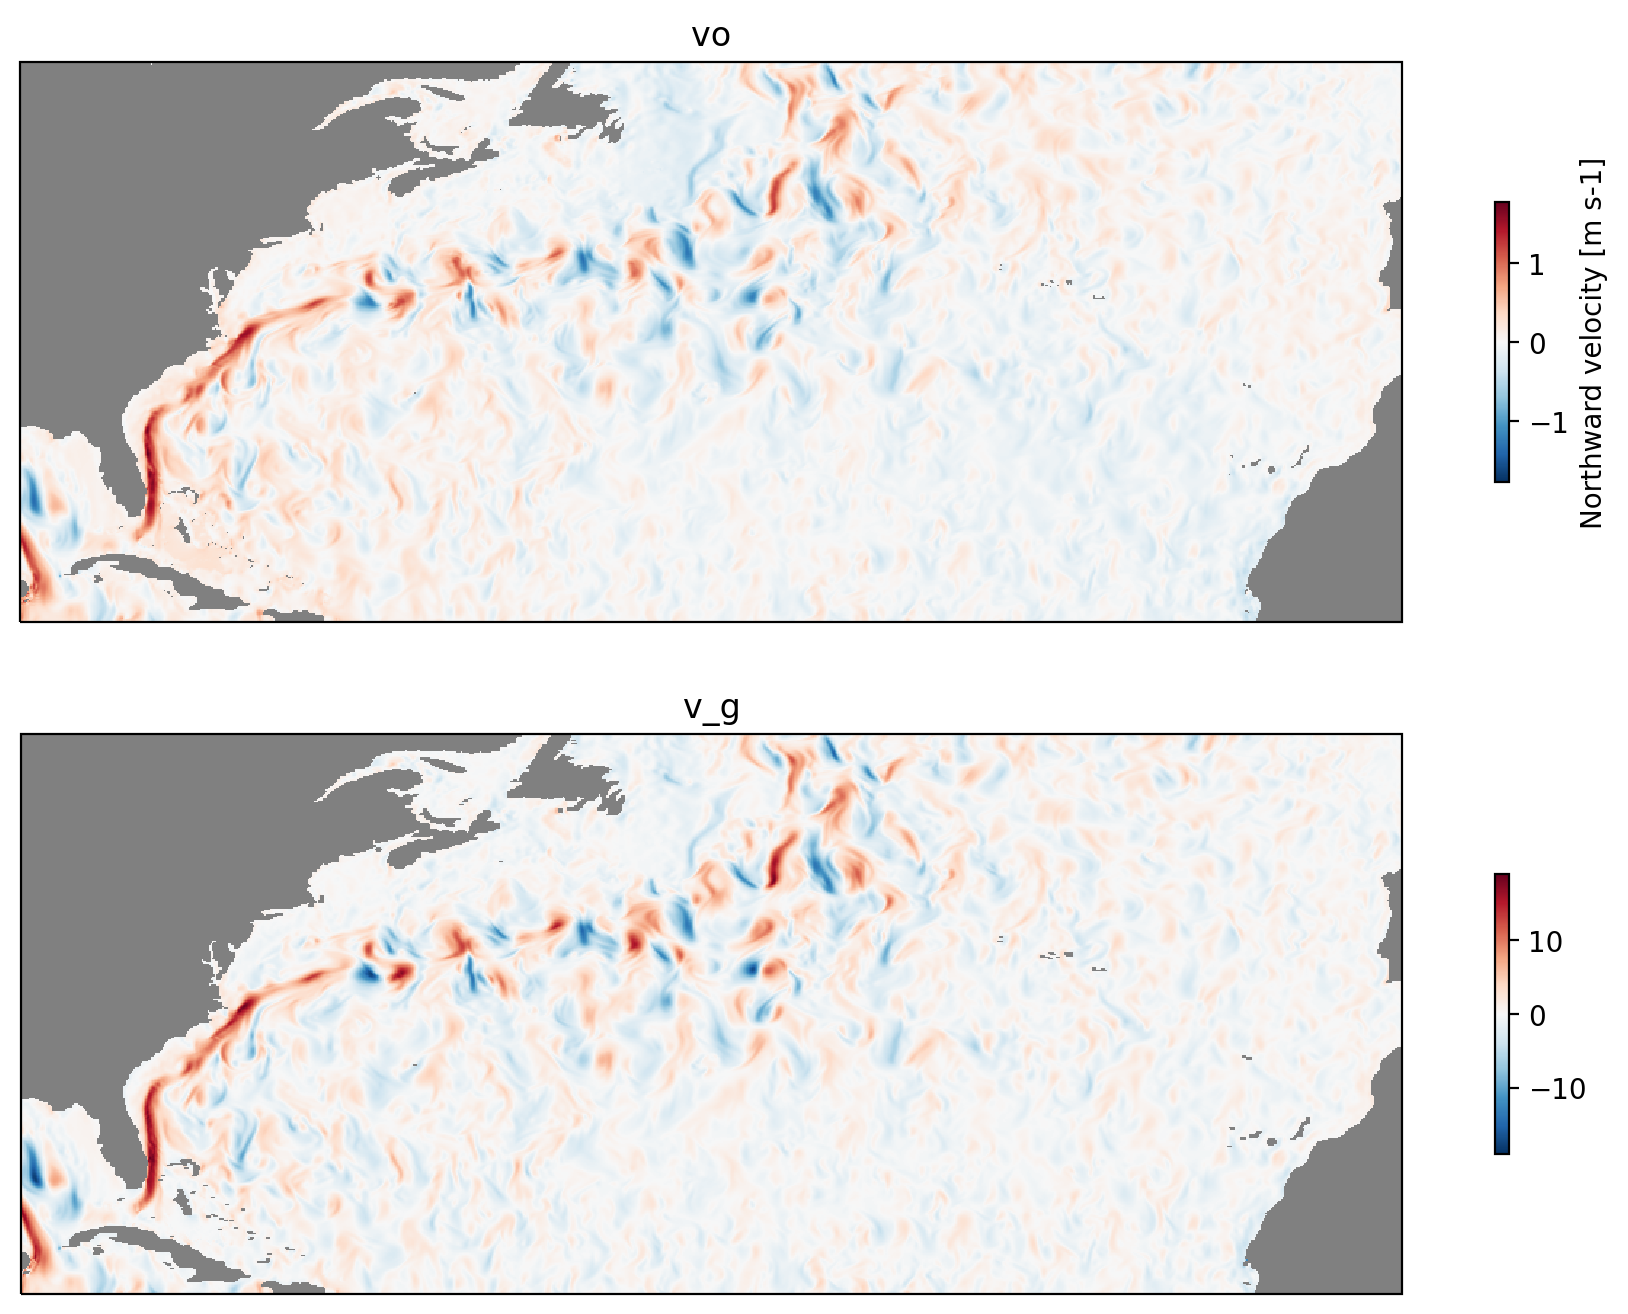

In [101]:
f, ax = plt.subplots(figsize=(12, 8),
                     nrows=2,
                     subplot_kw={'projection':ccrs.PlateCarree()})

glorys_time_end.vo.plot(ax=ax[0], transform=ccrs.PlateCarree(), cbar_kwargs={'shrink':0.5})

v_g_time_end.plot(ax=ax[1], transform=ccrs.PlateCarree(), cbar_kwargs={'shrink':0.5})

ax[0].set_facecolor('gray')
ax[0].set_title('vo')

ax[1].set_facecolor('gray')
ax[1].set_title('v_g')

# I think geostrophic velocities should be must more similar than uo and vo than they are here. Geostrophic velocities are an order of magnitude larger than prognostic velocities.

# At any given time slice, the difference between prognistic and geostrophic velocities may be much greater than in the time mean.

## 2. how sensitive are results to the length scale over which a gradient is calculated? (remember velocities have to be averaged across the same length scale). Choose a second length scale to compute gradient and estimate velocity difference (think of center difference methods and/or linear slope fitting)

# The SSH gradient between two nearby points could be much higher than the gradient between two distant points. If for example, there is a 1 meter change in sea level between two points that are 1 km apart, that gradient will 10 times greater than a 1 meter difference over 10 km. Since the maximum relief in SSH is ~2 m, we would expect the gradient to generally decrease as distance increases.

# However, I can't get preceding code to work to do this correctly

In [84]:
# Compute gradients of SSH
gloryis_zos_30W_30N = glorys_time_mean.zos.sel(longitude=-30, method='nearest').sel(latitude=30, method='nearest')
gloryis_zos_30W_31N = glorys_time_mean.zos.sel(longitude=-30, method='nearest').sel(latitude=31, method='nearest')
gloryis_zos_30W_35N = glorys_time_mean.zos.sel(longitude=-30, method='nearest').sel(latitude=35, method='nearest')

# dy = 1852 * 60 * (lat_n - lat_n-1)¶
dy1 = 1852 * 60 * abs((np.deg2rad(gloryis_zos_30W_30N.latitude) - np.deg2rad(gloryis_zos_30W_31N.latitude)))
dy2 = 1852 * 60 * abs((np.deg2rad(gloryis_zos_30W_30N.latitude) - np.deg2rad(gloryis_zos_30W_35N.latitude)))


In [88]:
grad_close = abs(gloryis_zos_30W_30N.values - gloryis_zos_30W_31N.values) / dy1
grad_far = abs(gloryis_zos_30W_30N.values - gloryis_zos_30W_35N.values) / dy2

print(f'ssh gradient over 1 degree: {grad_close}\n')
print(f'ssh gradient over 5 degrees: {grad_far}')


ssh gradient over 1 degree: 4.833927891819533e-05

ssh gradient over 5 degrees: 1.5094301571446573e-05


# through brute force, the above shows the difference in SSH gradient over 1 degree of latitude vs 5 degrees of latitude. Over 5 degrees of latitude, the SSH gradient is roughly 5 times smaller than over 1 degree because the difference in SSH is similar, but the distance the gradient is computed over is 5 times greater.

## 3. compute relative vorticity at a single time slice and for the time mean

# $$ \zeta = \frac{dv}{dx} - \frac{du}{dy} $$ and,
# $$ PV = \frac{\zeta + f}{h}  $$

In [89]:
# In theory this shouldn't be hard, but my gradients are clearly not computed correctly